# Doubly constrained gravity model

For a given:
* set of origins $i$ and destinations $j$ 
* production at origins vector $O_i$
* attraction at destinations vector $D_j$
* distance (cost) matrix between origins and destinations $C_{ij}$
* cost function for the decay/gravity function $T_{ij}=exp(-\beta C_{ij})$

Compute:
* trip matrix $T_{ij}$ such that
* $\sum_{i \in O} T_{ij} = O_i \forall j \in O$
* $\sum_{j \in D} T_{ij} = D_i \forall i \in D $


In [22]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotmap import DotMap
import os
import math

let's import some network - nodes are zones of the network

In [7]:
inData = DotMap()
for file in os.listdir('./wichita'):
    if file.startswith('wichita'):
        df = pd.read_csv('wichita/{}'.format(file), header = None)
        
        df = pd.DataFrame(df.values.reshape(464,int(df.shape[0]/464)))
        print(file[8:-4],df.shape)
        inData[file[8:-4]] = df

full_xij (464, 464)
dist (464, 464)
full_xij_k1 (464, 464)
full_xij_k3 (464, 464)
full_xij_k2 (464, 464)
oik (464, 3)
djk (464, 3)


In [16]:
O = inData.oik[0]
D = inData.djk[0]
O.sum(), D.sum()

(89949, 101024)

In [17]:
C = inData.dist

In [42]:
def doubly_constrained(O, D, C, beta = 0.1, plot = True, normalize = True, max_ite = 10000, eps = 0.01):
    """
    Computes trip matrix
    O - pandas series of origin flow from each zone
    D - pandas series of destination flows towards each zone
    C - cost matrix (distance) between the zones (pd.DataFrame)
    beta - parameter in the gravity model (enters with negative sign into the model)
    plot - flag to print iterations and plot results on the graphs
    max_ite - maximal number of iterations
    eps - error (Total Squared error) at which balancing terminates
    """
    if normalize and abs(O.sum() - D.sum()) / D.sum() > eps: # see if sums match
        D = D*O.sum()/D.sum() # adjust D to O
        
    def fun(x):
        return np.exp(-beta*x)
    O = O.values # rows
    A = np.ones_like(O)
    D = D.values # columns
    B = np.ones_like(D)
    F = C.apply(np.vectorize(fun))
    for i in range(max_ite):
        T = np.outer(O*A,D*B)*F
        A = np.reciprocal((B*D*F).sum(1))
        T = np.outer(O*A,D*B)*F       
        B = np.reciprocal((A*O*(F.T)).sum(1))
        if max(((T.sum(1)-O)**2).sum(),((T.sum(0)-D)**2).sum()) < eps:
            break
        if plot and i % 1 ==0:
            print("Iteration: {}\t total: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f}".format(i,
                                                                             T.sum().sum(),
                                                                             ((T.sum(1)-O)**2).sum(),
                                                                             ((T.sum(0)-D)**2).sum()))
            
    H = T.stack().to_frame()
    H.columns = ['flow']
    H['cost'] = C.stack()
    mean_cost = (H.cost*H.flow).sum()/H.flow.sum()
    cost_var = (H.cost*H.flow).std()
    print("Ite: {}\t demand:{:.2f}\t trips: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f} cost mean: {:.2f}\t var: {:.2f}".format(i,
                                                                                                                               O.sum(),
                                                                                                                               T.sum().sum(),
                                                                                                                               ((T.sum(1)-O)**2).sum(),
                                                                                                                               ((T.sum(0)-D)**2).sum(),
                                                                                                                               mean_cost, cost_var))
    if plot:
        fig, axes = plt.subplots(1,4,figsize = (15,5))
        axes = axes.flatten()
        #productions
        ((T.sum(1)-O)/O).hist(ax=axes[0]) # error at origins
        axes[0].set_title('Error at origins deistibution')
        ((T.sum(0)-D)/D).hist(ax=axes[1]) # error at destinations
        axes[1].set_title('Error at destinations deistibution')
        H['flow'].plot(kind='hist', weights = H['cost'], ax = axes[2], bins = 100) # trip distance distribution
        axes[2].set_xlim(0,H['flow'].quantile(0.99))
        axes[2].set_title('Trip distance distribution')
        
        
        x=np.linspace(C.min().min(),C.max().max(), 200)
        axes[3].plot(x,fun(x))
        axes[3].set_title('Theoretical impedance')

    return T

Iteration: 0	 total: 89949.00	 error_O: 0.00	 error_D: 267168.85
Iteration: 1	 total: 89949.00	 error_O: 0.00	 error_D: 0.05
Ite: 2	 demand:89949.00	 trips: 89949.00	 error_O: 0.00	 error_D: 0.00 cost mean: 11.60	 var: 21.71


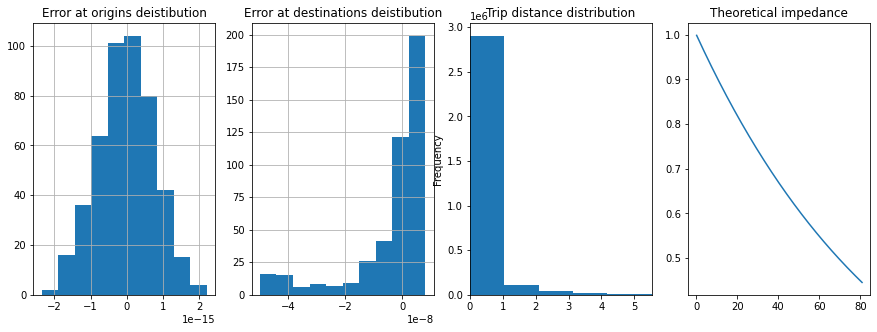

In [46]:
T = doubly_constrained(O, D, C, beta = 0.01, plot = True)

In [47]:
T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,462,463
0,0.07,0.19,0.18,0.20,0.03,0.34,0.02,0.25,0.54,0.86,...,0.00,0.00,0.05,0.00,0.02,0.03,0.21,0.02,0.14,0.09
1,0.05,0.18,0.15,0.16,0.02,0.25,0.01,0.22,0.48,0.72,...,0.00,0.00,0.04,0.00,0.01,0.02,0.20,0.02,0.13,0.08
2,0.11,0.35,0.32,0.33,0.04,0.56,0.03,0.43,0.98,1.57,...,0.01,0.01,0.09,0.01,0.03,0.05,0.39,0.04,0.26,0.16
3,0.12,0.39,0.33,0.47,0.05,0.57,0.03,0.55,1.02,1.61,...,0.01,0.01,0.09,0.01,0.03,0.05,0.43,0.04,0.28,0.17
4,0.08,0.22,0.20,0.23,0.03,0.36,0.02,0.29,0.60,0.96,...,0.01,0.01,0.05,0.00,0.02,0.03,0.24,0.02,0.16,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,0.05,0.19,0.16,0.17,0.02,0.30,0.02,0.23,0.64,0.79,...,0.01,0.01,0.07,0.01,0.02,0.04,0.33,0.03,0.22,0.14
460,0.02,0.09,0.07,0.08,0.01,0.13,0.01,0.10,0.28,0.35,...,0.00,0.00,0.04,0.00,0.01,0.02,0.18,0.02,0.12,0.07
461,0.02,0.07,0.06,0.07,0.01,0.11,0.01,0.09,0.24,0.30,...,0.00,0.00,0.03,0.00,0.01,0.02,0.15,0.02,0.10,0.06
462,0.05,0.19,0.16,0.17,0.02,0.30,0.02,0.23,0.64,0.79,...,0.01,0.01,0.09,0.01,0.02,0.04,0.40,0.04,0.28,0.17


----
(c) Rafal Kucharski, 2022